# ISLP - Chapter 9 - Exercise 7
### Author: pzuehlke

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from ISLP.svm import plot as plot_svm

__7 (a):__

In [2]:
auto = pd.read_csv("Auto.csv")
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           397 non-null    float64
 1   cylinders     397 non-null    int64  
 2   displacement  397 non-null    float64
 3   horsepower    397 non-null    object 
 4   weight        397 non-null    int64  
 5   acceleration  397 non-null    float64
 6   year          397 non-null    int64  
 7   origin        397 non-null    int64  
 8   name          397 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.0+ KB


When trying to fit the classifier in item (b) one quickly runs into errors due
to the fact that some values in the `horsepower` column have the value '?'; so
let's remove them and convert the datatype to float.

In [3]:
auto["horsepower"] = auto["horsepower"].replace('?', np.nan).astype(float)
auto.dropna(inplace=True)
auto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


In [4]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


Now let's create a new column titled `high_mpg` that takes on the value $ 1 $ or
$ 0 $ according to whether the car has achieves a gas mileage higher than the
median or not.

In [5]:
median_mpg = auto["mpg"].median()
auto["high_mpg"] = (auto["mpg"] > median_mpg).astype(int)
print(f"Median mpg: {median_mpg}")
print(f"Cars with high mpg: {sum(auto['high_mpg'])}, low mpg: {len(auto) - sum(auto['high_mpg'])}")

Median mpg: 22.75
Cars with high mpg: 196, low mpg: 196


__7 (b):__ Let's create the response and feature matrix, which consists of every
variable except `mpg`, `high_mpg` and `name`:

In [6]:
feature_cols = [col for col in auto.columns if col not in ["mpg", "high_mpg", "name"]]
X = auto[feature_cols]
y = auto["high_mpg"]

Before fitting the model, we will standardize the features since
SVC involves the distances $ \Vert x_i - x_{i'}\Vert  $ between observations.

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Now let's fit the SVC for various values of the regularization parameter $ C $
and compute the respective cross-validation errors. The code in the following
cell takes over $ 20 $ seconds to run.

In [23]:
C_values = np.logspace(-4, 5, 10).tolist()

linear_cv_errors = []
for C in C_values:
    svc = SVC(kernel="linear", C=C)
    scores = cross_val_score(svc, X_scaled, y, cv=5, scoring="accuracy")
    linear_cv_errors.append(1 - scores.mean())  # Convert accuracy to error

for C, error in zip(C_values, linear_cv_errors):
    print(f"C = {C}  \tCV error = {error:.4f}")

C = 0.0001  	CV error = 0.3769
C = 0.001  	CV error = 0.1459
C = 0.01  	CV error = 0.0996
C = 0.1  	CV error = 0.1249
C = 1.0  	CV error = 0.1477
C = 10.0  	CV error = 0.1426
C = 100.0  	CV error = 0.1426
C = 1000.0  	CV error = 0.1426
C = 10000.0  	CV error = 0.1426
C = 100000.0  	CV error = 0.1400


Let's plot these CV error rates against $ C $:

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.semilogx(C_values, linear_cv_errors, marker="o", linewidth=2)
ax.set_xlabel("$ C $ parameter (log scale)")
ax.set_ylabel("Cross-validation error")
ax.set_title("CV Error Rate for Support Vector Classifiers as a Function of $ C $")
ax.grid(linestyle="--", alpha=0.3)

fig.tight_layout()
plt.show()

The cross-validation error rates display the familiar $ U $-shaped pattern that
illustrates the bias-variance trade-off involved in the choice of the value of
$ C $. Among the values we have tried, the best error rate, approximately $ 10\%
$, is achieved for $ C = 10^{-2} $.

__7 (c):__ We first fit the SVMs with radial kernel:

In [24]:
gamma_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Cross-validation for RBF kernel:
rbf_cv_errors = {}
for C in C_values:
    for gamma in gamma_values:
        svc = SVC(kernel="rbf", C=C, gamma=gamma)
        scores = cross_val_score(svc, X_scaled, y, cv=5, scoring="accuracy")
        rbf_cv_errors[(C, gamma)] = 1 - scores.mean()

sorted_rbf_errors = {k: v for k, v in sorted(
        rbf_cv_errors.items(), key=lambda item: item[1]
)}

title = "RBF kernel SVM cross-validation error rates:"
print(title + '\n' + "-" * len(title))
for (C, gamma), error in sorted_rbf_errors.items():
    print(f"C = {C},\t gamma = {gamma},\t\tCV error = {error:.4f}")

RBF kernel SVM cross-validation error rates:
--------------------------------------------
C = 0.1,	 gamma = 1,		CV error = 0.0944
C = 0.1,	 gamma = 0.1,		CV error = 0.0945
C = 1.0,	 gamma = 0.01,		CV error = 0.0996
C = 10.0,	 gamma = 0.001,		CV error = 0.1021
C = 0.1,	 gamma = 0.01,		CV error = 0.1202
C = 1.0,	 gamma = 0.001,		CV error = 0.1228
C = 10.0,	 gamma = 0.01,		CV error = 0.1326
C = 1.0,	 gamma = 1,		CV error = 0.1349
C = 100.0,	 gamma = 0.001,		CV error = 0.1351
C = 0.01,	 gamma = 0.1,		CV error = 0.1353
C = 1.0,	 gamma = 0.1,		CV error = 0.1377
C = 1000.0,	 gamma = 0.001,		CV error = 0.1477
C = 100.0,	 gamma = 0.01,		CV error = 0.1554
C = 10000.0,	 gamma = 0.001,		CV error = 0.1682
C = 10.0,	 gamma = 1,		CV error = 0.1808
C = 10000.0,	 gamma = 0.1,		CV error = 0.1960
C = 100000.0,	 gamma = 0.1,		CV error = 0.1986
C = 10.0,	 gamma = 0.1,		CV error = 0.1988
C = 100.0,	 gamma = 1,		CV error = 0.2013
C = 1000.0,	 gamma = 1,		CV error = 0.2013
C = 10000.0,	 gamma = 1,		CV error =

Thus, using an SVM with a radial kernel, the best CV error rate, $ 9.44\% $,
is only slightly better than the one achieved by the SVC. However, notice
that the preceding code executed about $ 20 $ times faster than the one
fitting the SVC models, even for the SVM we considered $ 6 $ times the number
of variants as for the SVC (because we tried six values of $ \gamma $).

Now let's try SVMs with polynomial kernels of varying degrees:

In [25]:
degrees = [2, 3, 4, 5]

# Cross-validation for polynomial kernel:
poly_cv_errors = {}
for C in C_values:
    for degree in degrees:
        svc = SVC(kernel="poly", C=C, degree=degree)
        scores = cross_val_score(svc, X_scaled, y, cv=5, scoring="accuracy")
        poly_cv_errors[(C, degree)] = 1 - scores.mean()


sorted_poly_errors = {k: v for k, v in sorted(
        poly_cv_errors.items(), key=lambda item: item[1]
)}

title = "Polynomial kernel SVM cross-validation error rates:"
print(title + '\n' + "-" * len(title))

for (C, degree), error in sorted_poly_errors.items():
    print(f"C = {C},\t degree = {degree},\tCV error = {error:.4f}")

Polynomial kernel SVM cross-validation error rates:
---------------------------------------------------
C = 10.0,	 degree = 3,	CV error = 0.1346
C = 100.0,	 degree = 3,	CV error = 0.1347
C = 1000.0,	 degree = 5,	CV error = 0.1552
C = 10.0,	 degree = 5,	CV error = 0.1703
C = 100.0,	 degree = 5,	CV error = 0.1728
C = 1000.0,	 degree = 3,	CV error = 0.1756
C = 1.0,	 degree = 3,	CV error = 0.1805
C = 10000.0,	 degree = 5,	CV error = 0.1883
C = 100000.0,	 degree = 5,	CV error = 0.1959
C = 10000.0,	 degree = 3,	CV error = 0.1986
C = 100000.0,	 degree = 3,	CV error = 0.2089
C = 0.1,	 degree = 3,	CV error = 0.2252
C = 100.0,	 degree = 4,	CV error = 0.2438
C = 10.0,	 degree = 2,	CV error = 0.2521
C = 1000.0,	 degree = 2,	CV error = 0.2647
C = 100.0,	 degree = 2,	CV error = 0.2673
C = 100000.0,	 degree = 2,	CV error = 0.2723
C = 10.0,	 degree = 4,	CV error = 0.2796
C = 1000.0,	 degree = 4,	CV error = 0.2797
C = 10000.0,	 degree = 2,	CV error = 0.2800
C = 0.01,	 degree = 3,	CV error = 0.2812
C = 

Thus, using SVMs with polynomial kernels of degrees from $ 2 $ to $ 5 $ the best
CV error rate is a disappointing $ 13.46 \% $, clearly worse than the best SVC
and radial kernel SVM. However, this model still required less time to fit
than the SVC despite depending on $ 4 $ times more parameters (because we tried
$ 4 $ possible degrees).

__7 (d):__ I will plot only one pair of features below, `displacement` and
`weight`, because to be honest I didn't find the plots very insightful, especially
since we can't visualize all of the features at the same time. 

First let's remind ourselves of what the columns in $ X $ and their indices are:

In [39]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 396
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cylinders     392 non-null    int64  
 1   displacement  392 non-null    float64
 2   horsepower    392 non-null    float64
 3   weight        392 non-null    int64  
 4   acceleration  392 non-null    float64
 5   year          392 non-null    int64  
 6   origin        392 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 32.6 KB


We will plot the best SVC, the best SVM with radial kernel, and the best and
fourth-best SVM with polynomial kernel, having degrees $ 3 $ and $ 5 $,
respectively. The interested reader can easily select other pairs of features
and modify the code accordingly. 

Notice that the feature space is high-dimensional. The plots below
represent the _projections_ of the observations and decision boundaries
onto two dimensions. This means that the resulting diagrams can be deceiving,
because observations that lie on the same side of the "boundary" in the plot may
actually be separated by the SVM, even though we can't see that.

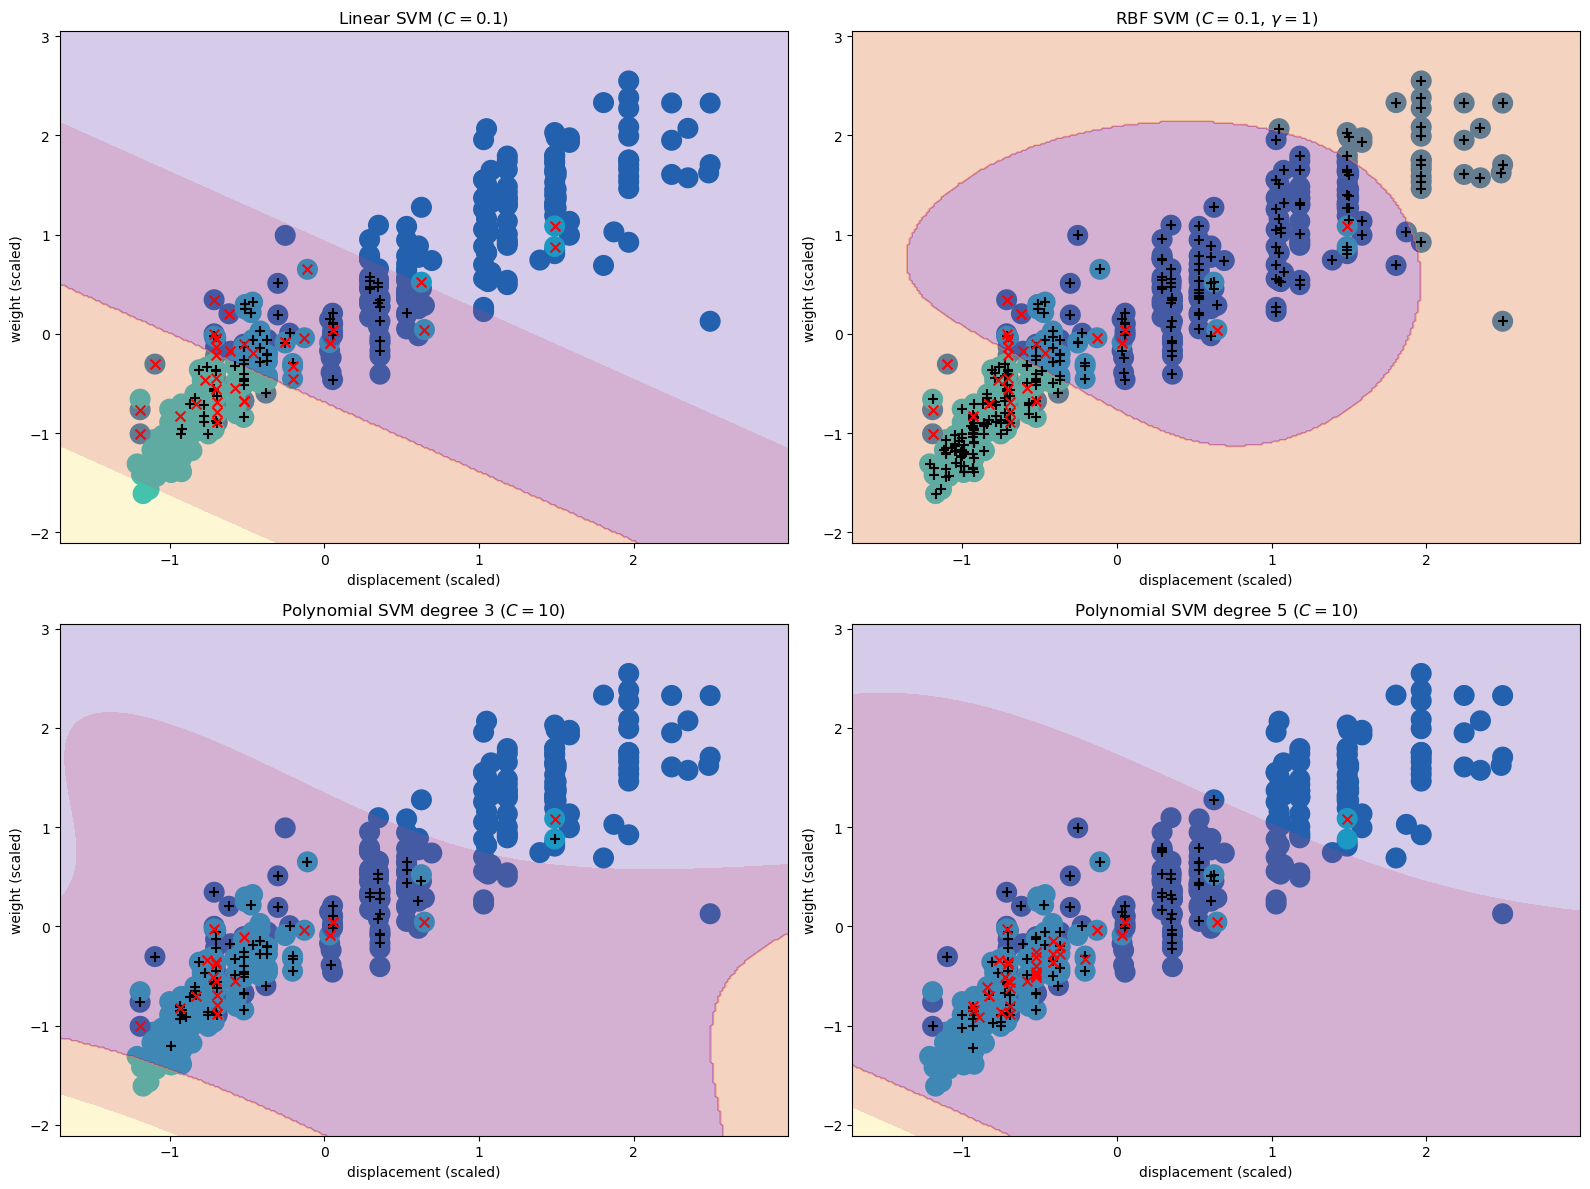

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # Flatten for easier indexing

C_linear = 10e-2
C_rbf = 0.1
C_poly = 10
gamma_rbf = 1

X_array = X_scaled
y_array = y.to_numpy()

# Linear SVM:
svc_linear = SVC(kernel="linear", C=C_linear)
svc_linear.fit(X_array, y_array)
# RBF SVM:
svc_rbf = SVC(kernel="rbf", C=C_rbf, gamma=gamma_rbf)
svc_rbf.fit(X_array, y_array)
# Polynomial SVM degree 3:
svc_poly3 = SVC(kernel="poly", C=C_poly, degree=3, gamma="scale")
svc_poly3.fit(X_array, y_array)
# Polynomial SVM degree 5:
svc_poly5 = SVC(kernel="poly", C=C_poly, degree=5, gamma="scale")
svc_poly5.fit(X_array, y_array)

# Plot linear SVM:
plot_svm(X_array, y_array, svc_linear, features=(1, 3), ax=axes[0])
axes[0].set_xlabel(X.columns[1] + " (scaled)")
axes[0].set_ylabel(X.columns[3] + " (scaled)")
axes[0].set_title(f"Linear SVM ($ C = {C_linear} $)")

# Plot RBF SVM:
plot_svm(X_array, y_array, svc_rbf, features=(1, 3), ax=axes[1])
axes[1].set_xlabel(X.columns[1] + " (scaled)")
axes[1].set_ylabel(X.columns[3] + " (scaled)")
axes[1].set_title(f"RBF SVM ($ C = {C_rbf} $, $ \\gamma = {gamma_rbf} $)")

# Plot Polynomial SVM degree 3:
plot_svm(X_array, y_array, svc_poly3, features=(1, 3), ax=axes[2])
axes[2].set_xlabel(X.columns[1] + " (scaled)")
axes[2].set_ylabel(X.columns[3] + " (scaled)")
axes[2].set_title(f"Polynomial SVM degree $ 3 $ ($ C = {C_poly} $)")

# Plot Polynomial SVM degree 5:
plot_svm(X_array, y_array, svc_poly5, features=(1, 3), ax=axes[3])
axes[3].set_xlabel(X.columns[1] + " (scaled)")
axes[3].set_ylabel(X.columns[3] + " (scaled)")
axes[3].set_title(f"Polynomial SVM degree $ 5 $ ($ C = {C_poly} $)")

fig.tight_layout()
plt.show()